In [1]:
import matplotlib.pyplot as plt

import pandas as pd

#import gym
import numpy as np
from stable_baselines3 import A2C, DDPG, SAC, PPO, TD3
from stable_baselines3.common.env_checker import check_env
from matplotlib import axis
#import numpy as np
from floris.tools import FlorisInterface

#Importing custom environment.
from Custom_functions import CustomEnv5, CustomEnv2
#import copy
from gym.envs.my_collection import FlorisEnv 

#import seaborn as sns
#from scipy import stats
import os
import matplotlib.pyplot as plt
import copy

In [2]:
model1 = A2C.load("models/A2C14/970000")    #trained on env2
model2 = A2C.load("models/A2C16/800000")    #trained on env5 
model3 = TD3.load("models/TD33/20000")      #trained on env2

In [3]:
env1 = CustomEnv2(t_steps = 100, dist = 5, nx = 3, ny = 3,
            turb_type = 'nrel_5MW', combination = 'sosfs', deflection = 'gauss',
            turbulence = 'crespo_hernandez', velocity = 'gauss',
            WS_min = 7, WS_max = 7, TI_min = 0.07, TI_max = 0.07, wd_min = 270, wd_max = 315, 
            yaw_max = 30, rho = 1.225, seed = 3)

In [4]:
env2 = CustomEnv5(t_steps = 10, dist = 5, nx = 3, ny = 3,
                    turb_type = 'nrel_5MW', combination = 'sosfs', deflection = 'gauss',
                    turbulence = 'crespo_hernandez', velocity = 'gauss',
                    WS_min = 7, WS_max = 7, TI_min = 0.07, TI_max = 0.07, wd_min = 270, wd_max = 315, 
                    yaw_max = 30, rho = 1.225, seed = 0)

In [5]:
env3 = CustomEnv2(t_steps = 100, dist = 5, nx = 3, ny = 3,
            turb_type = 'nrel_5MW', combination = 'sosfs', deflection = 'gauss',
            turbulence = 'crespo_hernandez', velocity = 'gauss',
            WS_min = 7, WS_max = 7, TI_min = 0.07, TI_max = 0.07, wd_min = 270, wd_max = 315, 
            yaw_max = 30, rho = 1.225, seed = 5)

In [6]:
winddir_test = np.arange(270, 316, 1)
envs = [env1, env2, env3]
models = [model1, model2, model3]
actions = np.zeros((len(models), len(winddir_test), 9)) #initialize array for the actions taken.
powers = np.zeros((len(models), len(winddir_test)) )     #Initialize array for the power of the farm.
powers_baseline = np.zeros(len(winddir_test))
yaw_zero = np.zeros((1, 1, 9)) 

In [7]:
#base farm
env1.reset()
base_fi = copy.deepcopy(env1.fi)

In [8]:
i = 0 #model number
power_baseline = 0
for env, model in zip(envs, models):
    env.reset()
    j = 0 #wind direction number
    for winddir in winddir_test:

        env.fi.reinitialize(
            wind_directions=[winddir],
            turbulence_intensity= 0.07,
            wind_speeds=[7]
            )

        obs_scaled = env.scale_obs(ws=np.array(7), wd=winddir, TI=np.array(0.07))
        action, _states = model.predict(obs_scaled, deterministic=True)
        actions[i, j, :] = action*env.yaw_max
        env.fi.calculate_wake(yaw_angles=np.array([[action*env.yaw_max]]))
        power = env.fi.get_farm_power()[0][0]
        powers[i,j] = power

        if i == 2:
            base_fi.reinitialize(
            wind_directions=[winddir],
            turbulence_intensity= 0.07,
            wind_speeds=[7]
            )

            base_fi.calculate_wake(yaw_angles= yaw_zero)
            power_baseline = base_fi.get_farm_power()[0][0]
            powers_baseline[j] = power_baseline

 
        j += 1
    i += 1
    print("Model ", i, "finished")

Model  1 finished
Model  2 finished
Model  3 finished


In [9]:
print("max yaw actions are:", actions[0,:,:].max(), actions[1,:,:].max(), actions[2,:,:].max())
print("min yaw actions are:", actions[0,:,:].min(), actions[1,:,:].min(), actions[2,:,:].min())

max yaw actions are: 5.424389362335205 15.411766052246094 7.981588840484619
min yaw actions are: -0.7356913685798645 -10.981128692626953 -2.1850972175598145


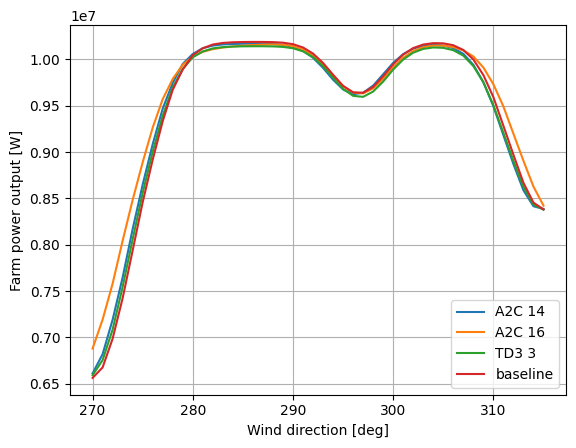

In [11]:
plt.plot(winddir_test, powers[0,:], label = "A2C 14")
plt.plot(winddir_test, powers[1,:], label = "A2C 16")
plt.plot(winddir_test, powers[2,:], label = "TD3 3")
plt.plot(winddir_test, powers_baseline, label = "baseline")
plt.xlabel("Wind direction [deg]")
plt.ylabel("Farm power output [W]")
plt.legend()
#plt.xlim([280, 290])
#plt.ylim([0.9*1e7, 1.1*1e7])
plt.grid()

plt.show()


In [12]:
total_powers = np.sum(powers, axis=1)
total_power_baseline = np.sum(powers_baseline)
print(total_powers, total_power_baseline)
print(total_powers - total_power_baseline)

[4.36620103e+08 4.40380706e+08 4.35198768e+08] 436174566.9353247
[ 445536.16993439 4206139.37996733 -975799.05222666]


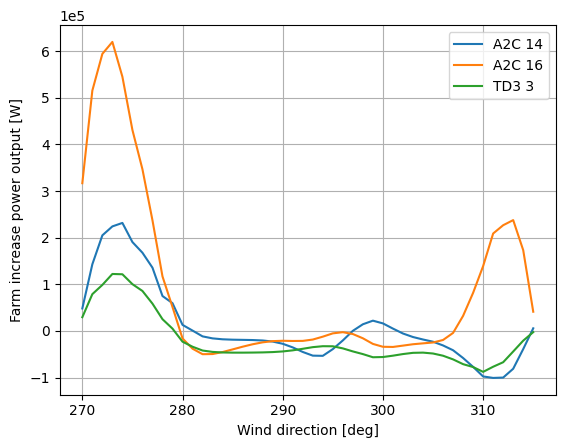

In [24]:

plt.plot(winddir_test, powers[0,:] - powers_baseline, label = "A2C 14")
plt.plot(winddir_test, powers[1,:] - powers_baseline, label = "A2C 16")
plt.plot(winddir_test, powers[2,:] - powers_baseline, label = "TD3 3")
#plt.plot(winddir_test, powers_baseline, label = "baseline")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel("Wind direction [deg]")
plt.ylabel("Farm increase power output [W]")
plt.legend()
#plt.xlim([280, 290])
#plt.ylim([0.9*1e7, 1.1*1e7])
plt.grid()

plt.show()

# BELOW IS LEGACY CODE

This then sets up the environment, according to the test document 

Then we load either PPO or A2C model:

Creates Floris class

Does the simulations for the wind directions 

In [14]:
TI = TI_min

actions = []
agent_power = []
baseline_power = []
wind_dirs = []
yaw_angles = np.zeros((1, 1, nx*ny)) 
yaw_zero = np.zeros((1, 1, nx*ny)) 

wind_speed = 7



ws_norm = (wind_speed - env.ws_range_min)/(env.ws_range_max - env.ws_range_min)
TI_norm = (TI - env.ti_range_min)/(env.ti_range_max - env.ti_range_min)  


for wind_dir in range(wd_min, wd_max+1):
    wind_dirs.append(wind_dir)
    wd_norm = (wind_dir - env.wd_range_min)/(env.wd_range_max - env.wd_range_min)
    #observation = np.array([self.wd_norm, self.ws_norm, self.TI_norm], dtype = np.float32)
    observation = np.array([wd_norm, ws_norm, TI_norm], dtype = np.float32)

    action, _states = model.predict(observation, deterministic=True)
    
    action = action*env.yaw_max   #scales the action to the 
    actions.append(action)
    
    fi.reinitialize(
        wind_directions=[wind_dir],
        turbulence_intensity= TI,
        wind_speeds=[wind_speed]
        )
    
    yaw_angles[0,0,:] = action
    fi.calculate_wake(yaw_angles = yaw_zero)
    
    baseline_power.append(fi.get_farm_power()[0][0])
    
    fi.calculate_wake(yaw_angles = yaw_angles)
    agent_power.append(fi.get_farm_power()[0][0])
        
        

actions = np.array(actions)
np.unique(actions,axis = 0)

baseline_power = np.array(baseline_power)
agent_power = np.array(agent_power)
wind_dirs = np.array(wind_dirs)

print("done")

done


In [15]:
print("The wind direction and the yaw angles are:")
for i in range(len(actions)):
    
    print(f"Wind dir: {wind_dirs[i]:.2f}|T 1:{actions[i,0]:.2f}|T 2:{actions[i,1]:.2f}|T 3:{actions[i,2]:.2f}|T 4:{actions[i,3]:.2f}|T 5:{actions[i,4]:.2f}|T 6:{actions[i,5]:.2f}|T 7:{actions[i,6]:.2f}|T 8:{actions[i,7]:.2f}|T 9:{actions[i,8]:.2f}")

    

The wind direction and the yaw angles are:
Wind dir: 270.00|T 1:3.95|T 2:4.42|T 3:-0.14|T 4:1.87|T 5:1.95|T 6:0.80|T 7:0.55|T 8:2.20|T 9:-0.82
Wind dir: 271.00|T 1:3.96|T 2:4.42|T 3:-0.15|T 4:1.87|T 5:1.95|T 6:0.80|T 7:0.55|T 8:2.21|T 9:-0.83
Wind dir: 272.00|T 1:3.96|T 2:4.43|T 3:-0.15|T 4:1.86|T 5:1.96|T 6:0.80|T 7:0.55|T 8:2.22|T 9:-0.84
Wind dir: 273.00|T 1:3.97|T 2:4.43|T 3:-0.15|T 4:1.85|T 5:1.96|T 6:0.81|T 7:0.55|T 8:2.23|T 9:-0.85
Wind dir: 274.00|T 1:3.98|T 2:4.44|T 3:-0.15|T 4:1.84|T 5:1.96|T 6:0.81|T 7:0.55|T 8:2.23|T 9:-0.86
Wind dir: 275.00|T 1:3.98|T 2:4.44|T 3:-0.16|T 4:1.84|T 5:1.96|T 6:0.81|T 7:0.56|T 8:2.24|T 9:-0.86
Wind dir: 276.00|T 1:3.99|T 2:4.44|T 3:-0.16|T 4:1.83|T 5:1.96|T 6:0.81|T 7:0.56|T 8:2.25|T 9:-0.87
Wind dir: 277.00|T 1:3.99|T 2:4.45|T 3:-0.16|T 4:1.82|T 5:1.97|T 6:0.81|T 7:0.56|T 8:2.26|T 9:-0.88
Wind dir: 278.00|T 1:4.00|T 2:4.45|T 3:-0.16|T 4:1.81|T 5:1.97|T 6:0.81|T 7:0.56|T 8:2.26|T 9:-0.89
Wind dir: 279.00|T 1:4.01|T 2:4.46|T 3:-0.17|T 4:1.80|T 5

In [376]:
x = np.array([20, 10, 5, 10])

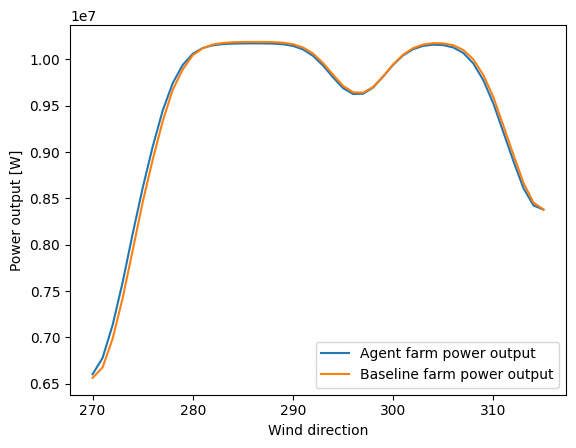

In [17]:
#Plots the power outputs

plt.plot(wind_dirs, agent_power, label = "Agent farm power output")
plt.plot(wind_dirs, baseline_power, label = "Baseline farm power output")
plt.ylabel('Power output [W]')
plt.xlabel('Wind direction')
plt.legend()
plt.show()

In [406]:
env.t_max + 1

101

In [404]:
len(wd_scaled)

101

In [18]:
obs_wd = []
obs_ws = []
obs_ti = []
rew = []
reward = 0
obs = env.reset()
i = 0
done = False
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, done, info = env.step(action)
    reward = reward + rewards
    obs_wd.append(obs[0])
    obs_ws.append(obs[1])
    obs_ti.append(obs[2])
    rew.append(rewards)
    print(done, i, rewards)
    i += 1
print("total reward:", reward)

obs_wd = np.array(obs_wd)
obs_ws = np.array(obs_ws)
obs_ti = np.array(obs_ti)
rew    = np.array(rew)

wd_scaled = obs_wd*(env.wd_range_max - env.wd_range_min) + env.wd_range_min
ws_scaled = obs_ws*(env.ws_range_max - env.ws_range_min) + env.ws_range_min
ti_scaled = obs_ti*(env.ti_range_max - env.ti_range_min) + env.ti_range_min


plt.plot(np.cumsum(rew))
plt.xlabel("simulation")
plt.ylabel("cumulative reward")
plt.show()


False 0 -0.17284872120081068
False 1 -0.7291383900880525
False 2 -0.2191691697108245
False 3 -0.7737091164480393
False 4 1.3967761999641186
False 5 -0.5697854103744693
False 6 -0.2077383696331213
False 7 -0.020356731748474376
False 8 -0.2880373606720728
False 9 -0.18143919675881448
False 10 1.406535622706243
False 11 -0.051836433589626404
False 12 -0.1588413722399925
False 13 2.2674915784539134
False 14 0.2680955404038668
False 15 -0.15198901995930797
False 16 -0.19385091124554843
False 17 1.1363037810524284
False 18 -0.2058750959536781
False 19 1.853093581874635
False 20 0.49638771211728194
False 21 2.112731772808727
False 22 -0.35338635449846917
False 23 -0.1119728203075391
False 24 -0.12047727659892493
False 25 1.688398835173234
False 26 2.2702916929798644
False 27 -0.07637767993612764
False 28 -0.18816153822211618
False 29 -0.04261657923244886
False 30 -0.13051625228054306
False 31 1.4744516382078359
False 32 -0.04177200065415999
False 33 -0.5804049117401788
False 34 -0.15000186750

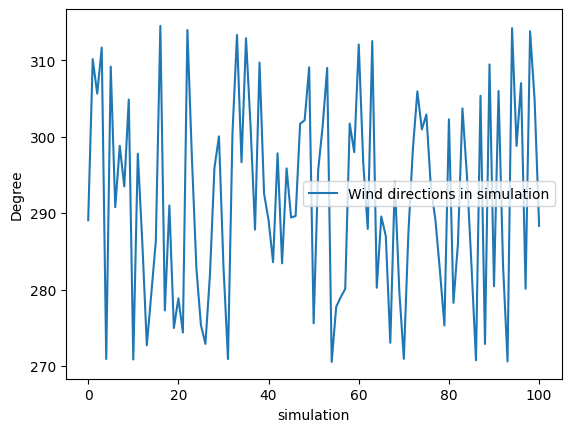

In [21]:
plt.plot(wd_scaled, label = "Wind directions in simulation")
plt.ylabel('Degree')
plt.xlabel('simulation')
plt.legend()
plt.show()

(array([12.,  9., 14.,  7.,  9., 10., 10., 12.,  8., 10.]),
 array([270.52713, 274.9221 , 279.31708, 283.71204, 288.107  , 292.50195,
        296.89694, 301.2919 , 305.68686, 310.08185, 314.4768 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

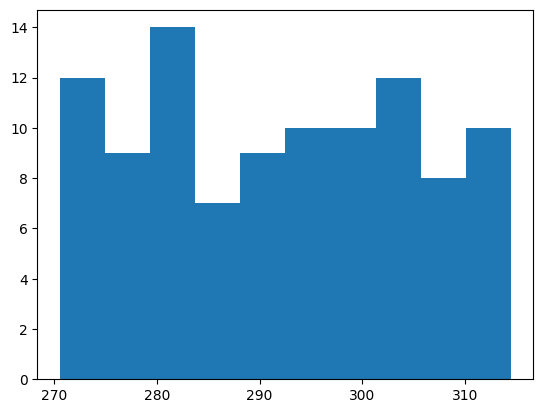

In [22]:
plt.hist(wd_scaled)

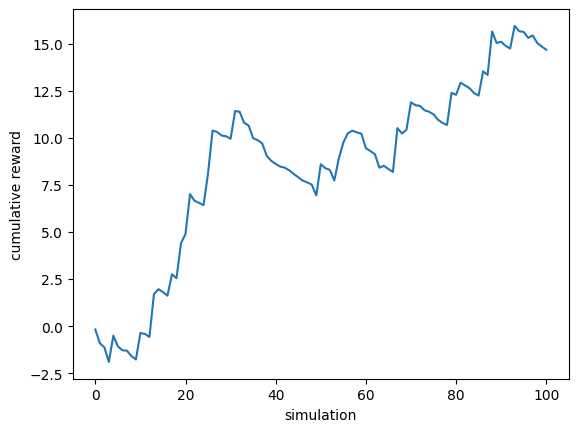

In [24]:
plt.plot(np.cumsum(rew))
plt.xlabel("simulation")
plt.ylabel("cumulative reward")
plt.show()

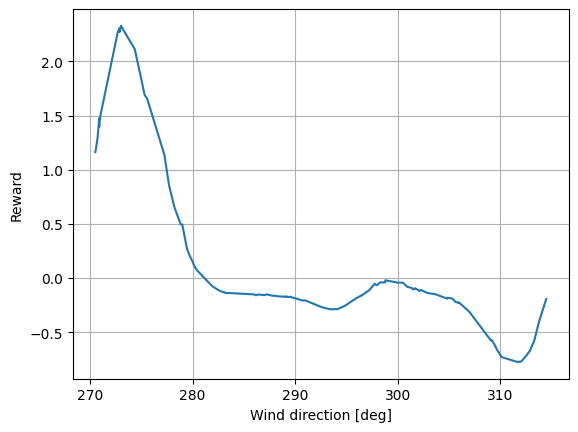

In [31]:
sort_ind = wd_scaled.argsort()
wd_sorted = wd_scaled[sort_ind[::-1]]
rew_sorted = rew[sort_ind[::-1]]

plt.plot(wd_sorted,rew_sorted)

plt.ylabel("Reward")
plt.xlabel("Wind direction [deg]")
plt.grid()
plt.show()

In [117]:
tensorboard dev upload --logdir logs/A2C4_0

UsageError: Line magic function `%tensorboard` not found.


,run,tag,step,value
0,A2C4_0,rollout/ep_len_mean,1000,95.444443
1,A2C4_0,rollout/ep_len_mean,2000,98.368423
2,A2C4_0,rollout/ep_len_mean,3000,99.275864
3,A2C4_0,rollout/ep_len_mean,4000,99.717949
4,A2C4_0,rollout/ep_len_mean,5000,99.979591
...,...,...,...,...
44529,TD32_0,train/learning_rate,473084,0.001000
44530,TD32_0,train/learning_rate,473488,0.001000
44531,TD32_0,train/learning_rate,473892,0.001000
44532,TD32_0,train/learning_rate,474296,0.001000
